In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys

import tensorflow as tf
from tensorflow.python.keras import layers
import tensorflow_probability as tfp
from tensorflow.python.keras.callbacks import Callback
from sklearn.model_selection import train_test_split

import keras.backend as K


import functions.parse_data as parse
import functions.models as md
import functions.handy_functions as hf

from keras.utils import plot_model
from IPython.display import Image

from tensorflow_probability import layers as tfpl

In [4]:
channel_labels= ['Cloud_B02','Cloud_B03','Cloud_B04','Cloud_B05','Cloud_B06','Cloud_B07',
                 'Cloud_B08','Cloud_B09','Cloud_B10','Cloud_B11','Cloud_B12','Cloud_B13']

data_water=parse.parse('cloudrm_water.dat')
data_clear=parse.parse('cloudrm_clear.dat')
data_ice=parse.parse('cloudrm_ice.dat')
data_mixed=parse.parse('cloudrm_mixed.dat')

#Concatinate all datasets
data_all=pd.concat([data_water, data_clear, data_ice, data_mixed])
data_all=data_all.drop(columns=['Surface_Desc','Cloud_B01','Clear_B01'])
data_all=hf.add_MSI_noise(data_all,channel_labels)


Noise standard deviation for Cloud_B02: 0.00335001428051948
Noise standard deviation for Cloud_B03: 0.002912530185416667
Noise standard deviation for Cloud_B04: 0.004058081082042254
Noise standard deviation for Cloud_B05: 0.0046524891611111115
Noise standard deviation for Cloud_B06: 0.007455351321348316
Noise standard deviation for Cloud_B07: 0.008871707484285717
Noise standard deviation for Cloud_B08: 0.04489677938000001
Noise standard deviation for Cloud_B09: 0.005688141120114942
Noise standard deviation for Cloud_B10: 0.003909328971491229
Noise standard deviation for Cloud_B11: 0.0014014724139999996
Noise standard deviation for Cloud_B12: 0.005030040539999999
Noise standard deviation for Cloud_B13: 0.004041267081999999


In [5]:
#Function taken from: https://github.com/sachinruk/KerasQuantileModel/blob/master/Keras%20Quantile%20Model.ipynb
#As a notebook from reading: https://towardsdatascience.com/deep-quantile-regression-c85481548b5a
def tilted_loss(q,y,f):
    e = (y-f)
    return K.mean(K.maximum(q*e, (q-1)*e), axis=-1)

In [6]:
##Train test validation split##
X_labels= ['Cloud_B02','Cloud_B03','Cloud_B04','Cloud_B05','Cloud_B06',
           'Cloud_B07','Cloud_B08','Cloud_B09','Cloud_B10','Cloud_B11','Cloud_B12','Cloud_B13',
           'Sat_Zenith_Angle','Sun_Zenith_Angle','Azimuth_Diff_Angle','Cloud_Type','Profile_ID','GOT','Water_Vapor']

#Leave out 'GOT', 'Water_Vapor'
#Band 1 no go.

y_labels=['COT']

df=hf.normalise_input_df(data_all,X_labels)
df=hf.add_noise(df,X_labels,sigma=0.001)
num_epochs=2
batch_size=100


##Split data##
X=df[X_labels]
y=df[y_labels]

X_train, y_train, X_val, y_val, X_test, y_test=hf.split_data(X,y,split=[0.9,0.05,0.05])





Simultaneous multiple quantiles instead of a new network for each quantile may be found in:
https://github.com/strongio/quantile-regression-tensorflow/blob/master/Quantile%20Loss.ipynb

In [7]:
from typhon.retrieval.qrnn.qrnn import QRNN

In [8]:
##Train test validation split##
X_labels= ['Cloud_B02','Cloud_B03','Cloud_B04','Cloud_B05','Cloud_B06',
           'Cloud_B07','Cloud_B08','Cloud_B09','Cloud_B10','Cloud_B11','Cloud_B12','Cloud_B13',
           'Sat_Zenith_Angle','Sun_Zenith_Angle','Azimuth_Diff_Angle','Cloud_Type','Profile_ID','GOT','Water_Vapor']

#Leave out 'GOT', 'Water_Vapor'
#Band 1 no go.

y_labels=['COT']

df=hf.normalise_input_df(data_all,X_labels)
df=hf.add_noise(df,X_labels,sigma=0.001)
num_epochs=2
batch_size=100


##Split data##
X=df[X_labels]
y=df[y_labels]

X_train, y_train, X_val, y_val, X_test, y_test=hf.split_data(X,y,split=[0.9,0.05,0.05])

model=tf.keras.Sequential([
    layers.Dense(32,input_dim=len(X_labels),activation='linear'),
    layers.Dense(64,activation='relu'),
    layers.Dense(64,activation='relu'),
    layers.Dense(64,activation='relu'),
    layers.Dense(len(y_labels),activation='linear')
])


In [9]:
quantiles=[0.1,0.5,0.9]
qrnn=QRNN(len(X_train.columns),quantiles=quantiles,model=(5,64,'relu'))

train_data_tuple=(X_train.values,y_train.values)
val_data_tuple=(X_val.values,y_val.values)

qrnn.train(training_data=train_data_tuple,
            initial_learning_rate = 0.01,
            learning_rate_minimum = 1e-4,
            batch_size=100,
            convergence_epochs=10,
            maximum_epochs=100,
            training_split=0.05)


Epoch 1/100


c:\Users\filip\AppData\Local\Programs\Python\Python311\Lib\site-packages\typhon\retrieval\qrnn\models\keras.py:448: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  self.fit_generator(


1800/1800 [==============================] - 4s 2ms/step - loss: 3.9694
Epoch 2/100
1800/1800 [==============================] - 3s 2ms/step - loss: 2.1997
Epoch 3/100
1800/1800 [==============================] - 3s 2ms/step - loss: 1.9019
Epoch 4/100
1800/1800 [==============================] - 3s 2ms/step - loss: 1.7642
Epoch 5/100
1800/1800 [==============================] - 3s 2ms/step - loss: 1.6546
Epoch 6/100
1800/1800 [==============================] - 3s 2ms/step - loss: 1.5813
Epoch 7/100
1800/1800 [==============================] - 3s 2ms/step - loss: 1.5291
Epoch 8/100
1800/1800 [==============================] - 3s 2ms/step - loss: 1.4783
Epoch 9/100
1800/1800 [==============================] - 3s 2ms/step - loss: 1.4393
Epoch 10/100
1800/1800 [==============================] - 3s 2ms/step - loss: 1.4054
Epoch 11/100
1800/1800 [==============================] - 3s 2ms/step - loss: 1.3760
Epoch 12/100
1800/1800 [==============================] - 3s 2ms/step - loss: 1.3539
E

In [12]:
y_pred=qrnn.predict(X_test.values)
y_pred_mean=qrnn.posterior_mean(X_test.values)

594/594 [==============================] - 1s 1ms/step


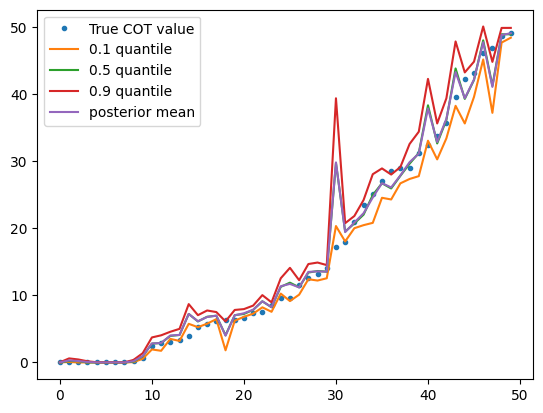

In [13]:
samples=50
y_plot=y_test[0:samples].to_numpy()[:,0]
sort_indices=np.argsort(y_plot)

y_plot_sort=y_plot[sort_indices]
y_pred_plot=y_pred[0:samples]
y_pred_plot_sort=y_pred_plot.copy()
for i in range(len(y_pred_plot[0,:])):
    tmp=y_pred_plot[:,i]
    tmp=tmp[sort_indices]
    y_pred_plot_sort[:,i]=tmp

y_pred_mean_plot_sort=y_pred_mean[0:samples]
y_pred_mean_plot_sort=y_pred_mean_plot_sort[sort_indices]

plt.plot(np.sort(y_plot_sort),'.')
plt.plot(y_pred_plot_sort)
plt.plot(y_pred_mean_plot_sort)
plt.legend(['True COT value',str(quantiles[0])+' quantile',str(quantiles[1])+' quantile',str(quantiles[2])+' quantile','posterior mean'])
plt.show()

In [25]:
print("MSE using median (quantile 0.5) as prediction: "+str(np.mean((y_test.to_numpy()[:,0]-y_pred[:,1])**2)))
print("MSE using posterior mean as prediction: "+str(np.mean((y_test.to_numpy()[:,0]-y_pred_mean)**2)))

MSE using median (quantile 0.5) as prediction: 4.390986595083303
MSE using posterior mean as prediction: 4.402524470878011
